# Analysis and plot of anatomical receptive field (RF) size

In [1]:
#%% Importing packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull, distance
from fafbseg import flywire
import navis
#from helper_anatomical_RF_analysis import *
from synapse_queries_helper import combine_xyz, calculate_neuron_weights, match_all_pre_to_single_post, calculate_spatial_span
from helper import replace_outliers_with_nan

C:\Users\sebas\anaconda3\envs\EM\lib\site-packages\blessed\terminal.py:186: UserWarning: Failed to setupterm(kind='xterm-color'): Could not find terminal xterm-color
  warnings.warn(msg)


In [2]:
#%% General plotting settings
PC_disc = 'D'
dataPath = f'{PC_disc}:\FlyWire-Data\Processed-data'
fig_save_path = os.path.join(dataPath,"Figures")
save_figures = True

#General style
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 8}
axes = {'labelsize': 12, 'titlesize': 12}
ticks = {'labelsize': 10}
legend = {'fontsize': 8}
plt.rc('font', **font)
plt.rc('axes', **axes)
plt.rc('xtick', **ticks)
plt.rc('ytick', **ticks)

#Saving text for pdfs in a proper way
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# For plotting purposes

hemisphere = 'R' 
neuropile_mesh = 'ME_L' # for fafbseq before version 2.0.0 (if later used, this should read: 'ME_R')
mesh_azim = 16
mesh_elev = -50 
cm = 1/2.54  # centimeters in inches

Total number of columns: 700
All presynatic partners: 
 ['Tm16', 'Mi4', 'CT1', 'L3', 'Dm12', 'C3', 'Tm20', 'Tm1', 'ML1', 'PS125', 'L4', 'C2', 'OA-AL2b2', 'TmY17', 'pMP7', 'TmY15', 'Mi13', 'Tm2', 'TmY10', 'Dm10', 'Mi9', 'Y3', 'T2', 'Tm23', 'TmY14', 'Dm3', 'Mi10', 'TmY11', 'Dm4', 'Tm4', 'Mi14', 'T5a', 'Dm15', 'Mi1', 'Dm20', 'Tm1a', 'Mi8', 'T5', 'Dm13', 'L2', 'Dm9', 'LC14b', 'Tm9', 'Tm5', 'Pm1a', 'T5c', 'T2a', 'T5b', 'TmY3', 'Lawf1', 'Tm5b', 'glia', 'R8', 'MeTu_m_l', 'Mt-N.I.', 'TmY21', 'TmY26', 'Me-Lo-2-N.I.', 'TmY24', 'TmY28', 'T3', 'TmY23', 'Mi?', 'glia ', 'Dm14', 'Dm8', 'L1', 'TmY25', 'TmY27', 'TmY22', 'Dm2', 'Dm1', 'TmY18', 'MeMe']
All presynatic partners after threshold: 
 ['Tm16', 'Mi4', 'CT1', 'L3', 'Dm12', 'C3', 'Tm20', 'Tm1', 'ML1', 'PS125', 'L4', 'C2', 'OA-AL2b2', 'TmY17', 'pMP7', 'TmY15', 'Mi13', 'Tm2', 'TmY10']


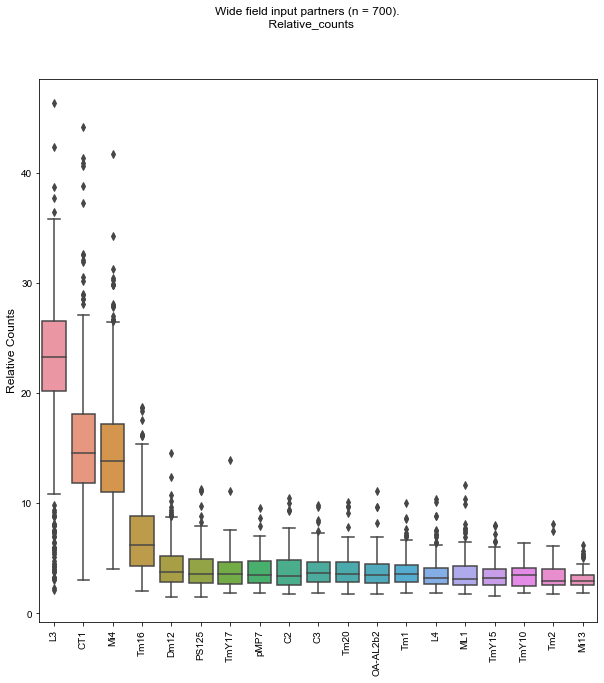

In [3]:
#%% Data analysis 
##################################################### Presynaptic partner analysis ########################################################
# Loading data
PC_disc = 'D'
dataPath = f'{PC_disc}:\Connectomics-Data\FlyWire\Processed-data'
fig_save_path = os.path.join(dataPath,"Figures")
save_figures = True

current_data = 'Tm9_700_R_20231113.xlsx'

filePath =  os.path.join(dataPath,current_data)
_sheet_name = 'Relative_counts'

data_df = pd.read_excel(filePath, sheet_name=_sheet_name,index_col = 0)
number_of_columns = len(data_df)
pre_partners_ls = data_df.columns.tolist()
print(f'Total number of columns: {number_of_columns}')
print(f'All presynatic partners: \n {pre_partners_ls}')

# Applying a presence threshold based on NaN values
percetatge_prescence = 0.05
threshold = percetatge_prescence * len(data_df)

# Filter columns based on the threshold
filtered_data_df = data_df.dropna(thresh=threshold, axis=1)
filtered_pre_partners_ls = filtered_data_df.columns.tolist()
print(f'All presynatic partners after threshold: \n {filtered_pre_partners_ls}')

# Visualization of sorted inputs from hight to low
_data = filtered_data_df
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)
fig.suptitle(f'Wide field input partners (n = {number_of_columns}). \n {_sheet_name}')
sns.boxplot(data=_data[_data.mean().sort_values(ascending = False).index], ax=axs)
axs.set_ylabel('Relative Counts')
axs.set_xticklabels(axs.get_xticklabels(), rotation=90) 
plt.show()
plt.close()

In [4]:
#%% Anatomical RF analysis (area and column span)

#Defined variables for analysis purposes
min_desired_count = 3 # minimun desired number of contacts between pre and post neurons to be considered
single_column_diameter = 11.2 # in um (measured in FlyWire)
single_column_area = 100 # in um^2 (Assumed column as circle)
hemisphere = 'R'




#############################################################################################
########## Matching all presynaptic cell ids connecting to each postsynaptic cell ###########

########## Looping across all presynaptic cell types

pre_neuron_type_ls = ['L3','Mi4','L4','Tm16','Dm12','C2','C3','Mi13','Tm1','Tm20','TmY10','TmY15','TmY17'] # add 
pre_neuron_type_ls = ['Dm12','L4'] 

spatial_span_df_dict = {}
individual_spatial_span_df_dict = {}

for pre_neuron_type in pre_neuron_type_ls:
    print(f'Analyzing {pre_neuron_type}')

    ## Loading information  from excel files
    PC_disc = 'D'
    dataPath = f'{PC_disc}:\Connectomics-Data\FlyWire\Excels\drive-data-sets\database'
    date = '20230912'
    post_neuron_type = 'Tm9'
    fileName_post = f'{post_neuron_type} proofreadings.xlsx'
    filePath_post = os.path.join(dataPath,fileName_post)
    fileName_pre = f'{pre_neuron_type} proofreadings.xlsx'
    filePath_pre = os.path.join(dataPath,fileName_pre)

    #Loading file as DataFrame
    post_df = pd.read_excel(filePath_post)
    pre_df = pd.read_excel(filePath_pre)

    ## Filtering data
    # Selecting the R optic lobe IDs
    R_pre_df = pre_df[pre_df['hemisphere'] == hemisphere].copy()
    R_post_df = post_df[post_df['hemisphere'] == hemisphere].copy()
    # Selecting the backbone proofread IDs
    R_post_df = R_post_df[R_post_df['backbone proofread (Y/N)'] == 'Y'].copy()
    R_pre_df = R_pre_df[R_pre_df['backbone proofread (Y/N)'] == 'Y'].copy()
    # Selecting presynaptic cells ids
    pre_ids = R_pre_df['Updated_seg_id'].tolist()
    print(f'Number of neurons: {len( pre_ids)}')

    # Quick updates
    # Updating presynaptic neurons if they are not up-to-date
    if not np.unique(flywire.is_latest_root(pre_ids))[0]: #if not up-to-date
        print('Consider updating your ids in the original pre-neuron data set')
        pre_ids_update_df = flywire.update_ids(pre_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
        up_to_date_pre_ids = pre_ids_update_df['new_id'].tolist()
    else:
        up_to_date_pre_ids = [int(x) for x in pre_ids]
        print('All pre ids were up to date')


        ## Getting postsynaptic side ID
    post_ids = R_post_df['Updated_seg_id'].tolist()

    ## Updating postsynaptic neurons if they are not up-to-date
    if not np.unique(flywire.is_latest_root(post_ids))[0]: # if not up-to-date
        print('Consider updating your ids in the original post neuron data set')
        #Updating the IDs via Fafbseg
        post_ids_update_df = flywire.update_ids(post_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
        up_to_date_post_ids = post_ids_update_df['new_id']
    else:
        up_to_date_post_ids = [int(x) for x in post_ids]
        print('All post ids were up to date')


    ## Doing the pre to post match
    pre_post_counts, post_inputs = match_all_pre_to_single_post(up_to_date_post_ids, up_to_date_pre_ids, neuropile_mesh) 

    #############################################################################################
    ## Analysis f spatial span of preynaptic inputs to single, unicolumnar, postsynaptic cells ##

    # Synaptic counts filter
    pre_post_counts = pre_post_counts[pre_post_counts['pre_syn_count']>=min_desired_count].copy()

    ## Geeting information for all pre cells 
    pre_ls = pre_post_counts['pre_pt_root_id'].tolist() # all postsynaptic neurons

    # Fetch the inputs from presynaptic cells
    #TODO change "pre_inputs" to "pre_connectivity" (which includes inputs and outputs)
    pre_inputs = flywire.synapses.fetch_synapses(pre_ls, pre=True, post=True, attach=True, 
                                                 min_score=50, clean=True, transmitters=False, 
                                                 neuropils=True, batch_size=30, 
                                                 dataset='production', progress=True,mat= "live")

    # Filtering: keeping only synapses in the medulla
    pre_inputs = pre_inputs[pre_inputs['neuropil'] == neuropile_mesh].copy()
    len(pre_inputs)

    #Combining pre- and postsynpases XYZ values in single columns
    combine_xyz(pre_inputs) # Function that does the operation

    ## Quantificatino of the spatial span
    spatial_span_df, individual_spatial_span_df = calculate_spatial_span(up_to_date_post_ids, up_to_date_pre_ids, post_ids_update_df, R_post_df, post_inputs, pre_post_counts, pre_inputs, single_column_area, single_column_diameter)
    spatial_span_df_dict[pre_neuron_type] = spatial_span_df
    



Analyzing Dm12
Number of neurons: 41
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/41 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating spatial span
Analyzing L4
Number of neurons: 73
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/73 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Calculating spatial span


In [7]:
## Combining all dataframes and discarding outliers

# Initialize an empty list to store DataFrames
dfs_list = []

# Iterate through the dictionary
for neuron, df in individual_spatial_span_df_dict.items():
    #Discard outliers
    df = replace_outliers_with_nan(df, multiplier=1.5)
    # Add 'neuron' column to the DataFrame
    df['neuron'] = neuron
    if len(df) < 10:
        continue
    # Append the DataFrame to the list
    dfs_list.append(df)

# Concatenate DataFrames in the list
combined_individual_spatial_span_df = pd.concat(dfs_list, ignore_index=True)

print('Analysis done.')

ValueError: No objects to concatenate